In [1]:
from nnsight import LanguageModel
import torch.nn.functional as F
import torch as th
from utils import plot_ci_plus_heatmap, plot_ci
import matplotlib.pyplot as plt

/users/eleves-b/2024/clement.dumas/english-llama/llm-latent-language/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nn_model = LanguageModel("croissantllm/CroissantLLMBase", device_map='auto', dispatch=True)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


In [3]:
print(nn_model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-23): 24 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5504, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5504, bias=False)
          (down_proj): Linear(in_features=5504, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Li

13091 9502 chien dog


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


output: torch.Size([2, 44, 32000]), logits: torch.Size([2, 24, 32000]),  hiddens: torch.Size([2, 24, 2048]), rms_out: torch.Size([2, 24, 2048])
layer_out: torch.Size([2, 2048]), probs: torch.Size([2, 24, 32000])
hiddens: torch.Size([2, 24, 2048])
torch.Size([2, 24, 32000])
tensor([3.6847e-16, 1.2163e-15, 2.5106e-16, 3.6976e-17, 1.7909e-13, 5.1155e-14,
        5.3412e-13, 3.0456e-13, 1.0748e-14, 1.2161e-16, 6.1484e-17, 2.0894e-12,
        1.4723e-11, 1.4745e-13, 3.2301e-12, 2.6833e-14, 9.6543e-14, 5.0355e-11,
        1.9274e-02, 9.4427e-01, 9.2990e-01, 9.9058e-01, 6.3211e-01, 8.6791e-01])
best tok: chien chien
tensor([13091, 13091]) 13091


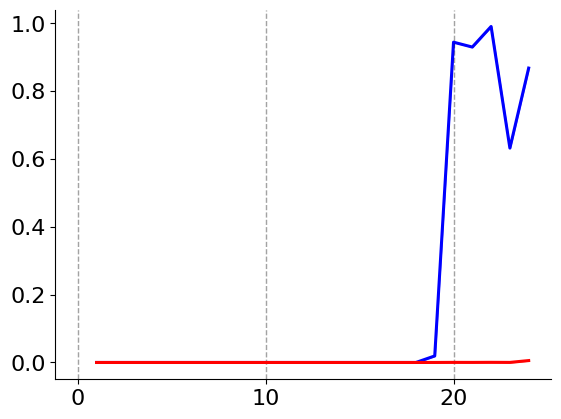

In [4]:
prompts = ["""The french translation for car is voiture
The french translation for hello is bonjour
The french translation for cat is chat
The french translation for hello is bonjour
The french translation for dog is"""] * 2
@th.no_grad
def logit_lens(nn_model, prompts):
      # nn_model.eval()
      with nn_model.trace(prompts) as tracer:
            layer_out = nn_model.model.layers[1].output[0].save()
            hiddens_l = [layer.output[0][:, -1].unsqueeze(1) for layer in nn_model.model.layers]
            hiddens = th.cat(hiddens_l, dim=1).save()
            rms_out = nn_model.model.norm(hiddens).save()
            logits = nn_model.lm_head(rms_out).save()
            output = nn_model.lm_head.output.save()
            probs = logits.softmax(-1).save()
      print(f"output: {output.shape}, logits: {logits.shape},  hiddens: {hiddens.shape}, rms_out: {rms_out.shape}")
      print(f"layer_out: {layer_out[:, -1].shape}, probs: {probs.shape}")
      print(f"hiddens: {hiddens.shape}")
      assert (logits[:, -1, :] == output[:, -1]).all()
      return probs

fr = nn_model.tokenizer("chien", add_special_tokens=False).input_ids[0]
# fr = 1210
en = nn_model.tokenizer("dog", add_special_tokens=False).input_ids[0]
print(fr, en, nn_model.tokenizer.decode(fr), nn_model.tokenizer.decode(en))
probs = logit_lens(nn_model, prompts)
print(probs.shape)
fig, ax = plt.subplots()
print(probs.cpu()[:, :, fr].mean(0))
plot_ci(ax, probs.cpu()[:, :, fr], label='fr')
plot_ci(ax, probs.cpu()[:, :, en], label='en', color='red')
# plt.plot()
print(f"best tok: {nn_model.tokenizer.decode(probs.cpu()[:, -1].argmax(1))}")
print(probs.cpu()[:, -1].argmax(1), fr)
assert (probs[:, -1, fr] == probs[:, -1].max(1).values).all()

# Models playgroudn

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "croissantllm/CroissantLLMBase"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=th.float16, device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


In [6]:
model.eval()
assert (tokenizer("dog") == nn_model.tokenizer("dog"))

In [8]:
# prompt = "The french translation for 'hello' is 'bonjour'\nThe french translation for 'head' is '"
prompt = prompts
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
tokens = model.generate(**inputs, max_new_tokens=1, do_sample=False)
print(tokenizer.decode(tokens[0]))

# remove bos token
print("\nWithout bos:")
inputs2 = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).to(model.device)
tokens2 = model.generate(**inputs2, max_new_tokens=1, do_sample=False)
print(tokenizer.decode(tokens2[0]))
print(tokens2[0][-1])


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> The french translation for car is voiture
The french translation for hello is bonjour
The french translation for cat is chat
The french translation for hello is bonjour
The french translation for dog is chien

Without bos:
The french translation for car is voiture
The french translation for hello is bonjour
The french translation for cat is chat
The french translation for hello is bonjour
The french translation for dog is chien
tensor(13091, device='cuda:0')
